In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from factor_analyzer import calculate_kmo, FactorAnalyzer
import pyreadstat

In [2]:
# Load the SPSS .sav file using pyreadstat
file_path = '/content/Mar19public.sav'
data, meta = pyreadstat.read_sav(file_path)

In [3]:
# Extract column names and labels
column_labels = meta.column_labels
value_labels = meta.value_labels

# Prepare the column descriptions
column_descriptions = [{"Variable Name": var, "Description": label} for var, label in zip(meta.column_names, meta.column_labels)]

# Convert to DataFrame for easier visualization
column_descriptions_df = pd.DataFrame(column_descriptions)

# Display the first few rows of column descriptions
print(column_descriptions_df.head())


  Variable Name                                        Description
0        respid  Individual unique respondent identification nu...
1        sample                                        Sample type
2      int_date  Interview date (NOTE: Final interviewer date, ...
3         fcall  Date of first call (NOTE: different from SRBI'...
4       attempt                            Number of call attempts


In [4]:
# Display the first few rows of the dataset
data.head()

,respid,sample,int_date,fcall,attempt,refusal,lang,cregion,state,usr,...,hh1,hh3,adults,ql1,ql1a,qc1,ll,cp,money2,weight
0,2.0,1.0,190320.0,190320.0,1.0,0.0,1.0,1.0,36.0,U,...,2.0,2.0,2.0,1.0,NaN,NaN,1.0,1.0,NaN,1.150112
1,3.0,1.0,190320.0,190320.0,1.0,0.0,1.0,1.0,42.0,U,...,1.0,NaN,1.0,2.0,NaN,NaN,1.0,0.0,NaN,2.092222
2,4.0,1.0,190320.0,190320.0,1.0,0.0,1.0,3.0,12.0,S,...,2.0,2.0,2.0,1.0,NaN,NaN,1.0,1.0,NaN,0.963393
3,5.0,1.0,190320.0,190320.0,1.0,0.0,1.0,3.0,37.0,R,...,2.0,2.0,2.0,1.0,NaN,NaN,1.0,1.0,NaN,0.489359
4,6.0,1.0,190320.0,190320.0,1.0,0.0,1.0,2.0,26.0,R,...,4.0,3.0,3.0,1.0,NaN,NaN,1.0,1.0,NaN,1.930009


In [5]:
# Summarize the data types and missing values
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Columns: 129 entries, respid to weight
dtypes: float64(126), object(3)
memory usage: 1.5+ MB


,0
respid,0
sample,0
int_date,0
fcall,0
attempt,0
...,...
qc1,300
ll,0
cp,0
money2,300


In [6]:
# Exploratory Data Analysis (EDA)
print("Summary Statistics:")
print(data.describe())

Summary Statistics:
              respid       sample       int_date          fcall      attempt  \
count    1503.000000  1503.000000    1503.000000    1503.000000  1503.000000   
mean    91914.548902     1.800399  190321.940120  190321.852961     2.263473   
std     55194.387510     0.399833       1.705831       1.697595     1.400890   
min         2.000000     1.000000  190320.000000  190320.000000     1.000000   
25%    100141.500000     2.000000  190320.000000  190320.000000     1.000000   
50%    100783.000000     2.000000  190322.000000  190321.000000     2.000000   
75%    101475.000000     2.000000  190324.000000  190323.000000     3.000000   
max    300009.000000     2.000000  190325.000000  190325.000000     8.000000   

           refusal         lang      cregion        state     scregion  ...  \
count  1503.000000  1503.000000  1503.000000  1503.000000  1503.000000  ...   
mean      0.027279     1.045908     2.679308    28.556221     2.644045  ...   
std       0.162949    

In [7]:
# Identify Variables for Political Opinion
pewopinion = data.iloc[:, 25:98]

print("Missing values before cleaning:")
print(pewopinion.isnull().sum().sum())

# Check rows with complete data across all selected columns
complete_cases = pewopinion.dropna(how="any")
print(f"\nNumber of original cases with complete data: {len(complete_cases)}")
print(f"Number of original cases with incomplete data: {len(pewopinion) - len(complete_cases)}")

# Identify columns where all rows are non-missing
complete_columns = pewopinion.columns[pewopinion.notna().all()]
print(f"\nNumber of items with complete data: {len(complete_columns)}")
print(f"Names of items with complete data: {list(complete_columns)}")

# Create a new DataFrame with only complete columns
pewwork = pewopinion[complete_columns]
print(pewwork.info())

print("Missing values after cleaning:")
print(pewwork.isnull().sum().sum())

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False)
design_matrix = encoder.fit_transform(pewwork)

# Convert the design matrix into a DataFrame
data_prepared = pd.DataFrame(
    design_matrix,
    columns=encoder.get_feature_names_out(pewwork.columns)
)
print(data_prepared.info())

Missing values before cleaning:
31370

Number of original cases with complete data: 0
Number of original cases with incomplete data: 1503

Number of items with complete data: 30
Names of items with complete data: ['q1', 'q2', 'q19', 'q20', 'q25', 'q47', 'q50a', 'q50b', 'q50c', 'q50d', 'q50e', 'q58', 'q60', 'q61a', 'q61b', 'q61c', 'q64', 'q65a', 'q65b', 'q65c', 'q65d', 'q65e', 'q66', 'q68a', 'q68b', 'q68d', 'q69', 'q70', 'q71', 'q75']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   q1      1503 non-null   float64
 1   q2      1503 non-null   float64
 2   q19     1503 non-null   float64
 3   q20     1503 non-null   float64
 4   q25     1503 non-null   float64
 5   q47     1503 non-null   float64
 6   q50a    1503 non-null   float64
 7   q50b    1503 non-null   float64
 8   q50c    1503 non-null   float64
 9   q50d    1503 non-null   float64
 10  q50e  

In [8]:
# Extract dummy column names and original column names
dummy_columns = data_prepared.columns.tolist()  # Get dummy column names
original_columns = pewwork.columns.tolist()  # Original column names before encoding

# Create mapping from dummy columns to original columns
mapping = {}
for dummy_col in dummy_columns:
    base_col = dummy_col.split('_')[0]  # Extract the original column name (before '_')
    mapping[dummy_col] = base_col

# Convert mapping to a DataFrame for easier handling
mapping_df = pd.DataFrame(list(mapping.items()), columns=["Dummy Column", "Original Column"])


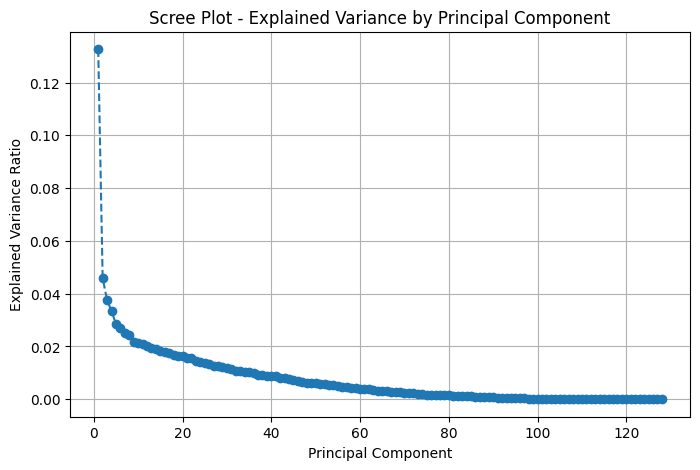

In [9]:
# Principal Component Analysis (PCA)
# Fit PCA to the data
pca = PCA()
pca_result = pca.fit_transform(data_prepared)

# Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Visualize Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Scree Plot - Explained Variance by Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


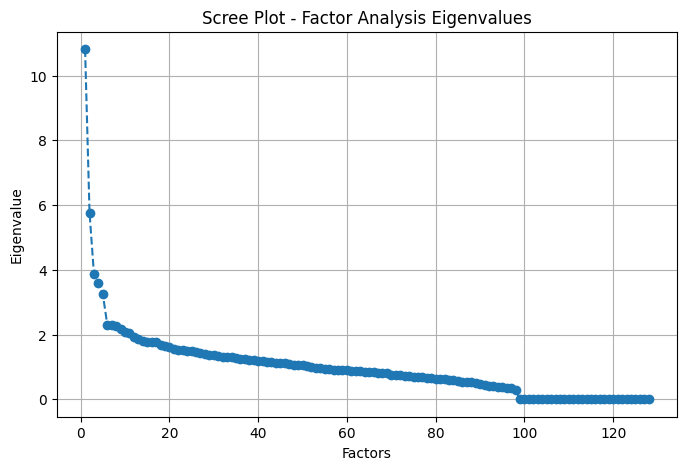

In [10]:
# Ensure `data` only includes variables used in the analysis
data_for_analysis = data_prepared.select_dtypes(include=[np.number])  # Keep only numeric columns

from factor_analyzer import calculate_kmo, FactorAnalyzer

# Calculate eigenvalues from Factor Analysis
fa = FactorAnalyzer(rotation=None)
fa.fit(data_for_analysis)
eigenvalues, _ = fa.get_eigenvalues()

# Plot Scree Plot for Factor Analysis
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker="o", linestyle="--")
plt.title("Scree Plot - Factor Analysis Eigenvalues")
plt.xlabel("Factors")
plt.ylabel("Eigenvalue")
plt.grid()
plt.show()


In [11]:
# According to the elbow point on the Scree Plot, first 7 factors are mannually chosen
mannual_n_factors = 7

# Run Factor Analysis with the selected number of factors
fa = FactorAnalyzer(n_factors=mannual_n_factors, rotation="varimax")
fa.fit(data_for_analysis)

# Extract and save factor loadings
factor_loadings = pd.DataFrame(
    fa.loadings_,
    index=data_for_analysis.columns,
    columns=[f"Factor{i+1}" for i in range(mannual_n_factors)]
)
print(factor_loadings)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


          Factor1   Factor2   Factor3   Factor4   Factor5   Factor6   Factor7
q1_1.0   0.484984 -0.034802  0.045533  0.351603 -0.150280 -0.154913 -0.164468
q1_2.0  -0.497428 -0.039732 -0.087586 -0.367589  0.147270  0.177197  0.119176
q1_9.0   0.061558  0.146479  0.083154  0.050584 -0.003998 -0.049525  0.074598
q2_1.0   0.811323  0.001232 -0.084988  0.089518  0.062667 -0.151085 -0.098578
q2_2.0  -0.798338 -0.095980  0.008945 -0.119375 -0.054667  0.199185  0.065274
...           ...       ...       ...       ...       ...       ...       ...
q71_9.0  0.005553  0.306568  0.086841  0.011491  0.069649 -0.069693  0.039822
q75_1.0 -0.110834 -0.157707 -0.476037 -0.263232  0.125307 -0.021125  0.079011
q75_2.0  0.078172  0.015769  0.391571  0.163400 -0.166158  0.000553 -0.063527
q75_3.0  0.070111  0.089603  0.216202  0.203865  0.062077  0.026956 -0.018673
q75_9.0  0.024652  0.424954 -0.004043 -0.003550 -0.038497  0.017589 -0.040859

[128 rows x 7 columns]


In [12]:
# Merge mapping with column descriptions
mapped_with_descriptions = pd.merge(
    mapping_df,
    column_descriptions_df,
    left_on="Original Column",
    right_on="Variable Name",
    how="left"
)

# Add descriptions back to the factor loadings
factor_loadings_with_desc = factor_loadings.reset_index()  # Reset index for merging
factor_loadings_with_desc = pd.merge(
    factor_loadings_with_desc,
    mapped_with_descriptions,
    left_on="index",  # Merge on dummy column names
    right_on="Dummy Column",
    how="left"
)

# Reorganize columns for readability
factor_loadings_with_desc = factor_loadings_with_desc[[
    "index", "Original Column", "Description", *factor_loadings.columns
]].rename(columns={"index": "Dummy Column"})


In [13]:
# Set threshold for high factor loadings
threshold = 0.4
high_loadings_results = []

# Iterate through factors and extract high loadings with descriptions
for factor in factor_loadings.columns:
    high_loadings = factor_loadings_with_desc[factor].abs() > threshold
    high_loading_vars = factor_loadings_with_desc[high_loadings]
    high_loadings_results.append(high_loading_vars[["Dummy Column", "Description", factor]])
    print(f"\nHigh loading variables for {factor}:")
    print(high_loading_vars[["Dummy Column", "Description", factor]])

high_loadings_df = pd.concat(high_loadings_results, ignore_index=True)
high_loadings_df.to_csv("high_loadings_results.csv", index=False)


High loading variables for Factor1:
    Dummy Column                                        Description   Factor1
0         q1_1.0  Q.1. All in all, are you satisfied or dissatis...  0.484984
1         q1_2.0  Q.1. All in all, are you satisfied or dissatis... -0.497428
3         q2_1.0  Q.2. Do you approve or disapprove of the way D...  0.811323
4         q2_2.0  Q.2. Do you approve or disapprove of the way D... -0.798338
20       q47_1.0  Q.47. From what you have seen or heard about e... -0.460349
21       q47_2.0  Q.47. From what you have seen or heard about e...  0.507190
23      q50a_1.0  Q50a. Business corporations make too much prof... -0.489206
24      q50a_2.0  Q50a. Business corporations make too much prof...  0.487289
27      q50b_1.0  Q50b. In foreign policy, the U.S. should take ... -0.505324
28      q50b_2.0  Q50b. In foreign policy, the U.S. should take ...  0.503625
35      q50d_1.0  Q.50d. The economic system in this country unf... -0.586166
36      q50d_2.0  Q.50d. Th